Plant Disease Classification Project: 
first we are importing all the necessary libraies and loading the dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras


In [26]:
image_size = (256,256)
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    labels='inferred',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    verbose=True
)

class_names = data_set.class_names
print(class_names)

Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


12


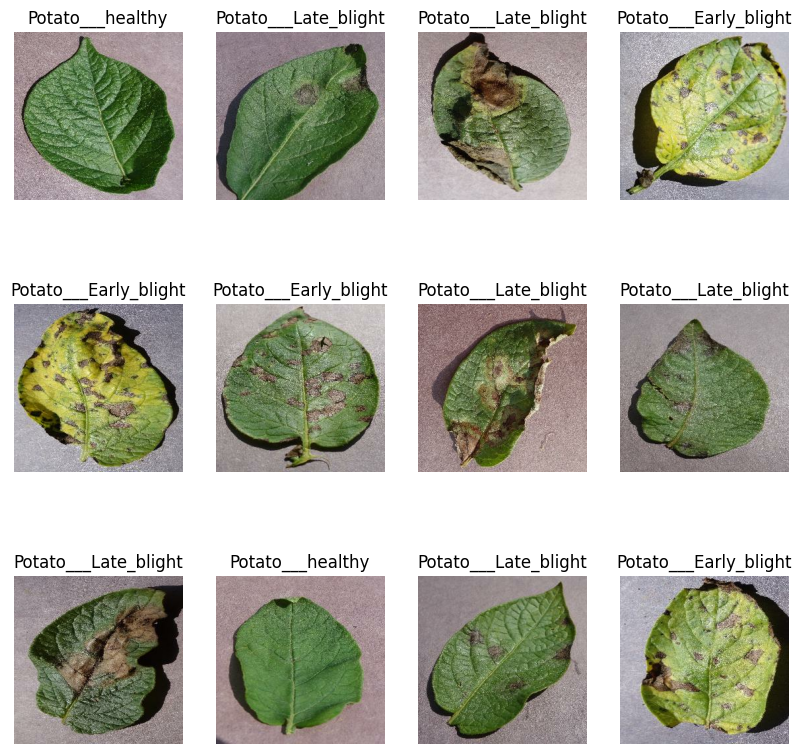

In [59]:
count = 0
plt.figure(figsize=(10,10))

for i in range(12):
    for img ,leb in data_set.take(1):
        plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(label= class_names[leb[i].numpy()])
        plt.axis("off")
        #print(img[0].numpy())
        count+=1
print(count)


In [55]:
for img,leb in data_set.take(1):
    print(class_names[leb[0].numpy()])

Potato___healthy


Now we are splitting the dataset in 3 parts train, validation, test dataset in a percentage of 80,10,10

In [70]:
def get_dataset_split(ds=data_set,training_fraction = 0.8 ,validation_fraction = 0.1,test_fraction=0.1,shuffle=True,shuffle_size=1000):
    print("getting started")
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    traing_dataset = ds.take(int(training_fraction*len(ds)))
    validation_dataset = ds.skip(int(training_fraction*len(ds))).take(int(validation_fraction*len(ds)))
    test_dataset = ds.skip(int(training_fraction*len(ds))).skip(int(validation_fraction*len(ds)))

    return traing_dataset,validation_dataset,test_dataset

In [75]:
int(len(data_set)*0.8)

54

In [76]:
train_dataset,val_dataset,test_dataset = get_dataset_split(data_set)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

getting started
54
6
8
